### Introduction

Yolo earned fame as it was the first method to entirely frame object detection as a singe regression problem. 
A single neural network predicts bounding-boxes and class probabilities directly from an input image. 
This naturally makes it really fast compared to previous methods, which would first propose potential reigons that contains bounding boxes in an image and then run a classifier seperately on those reigons to give class probabilities. 

There's already plenty of online reources on Yolo, ever since the first version of the method was introduced in 2016 [3]. Also, there are now four versions of this algorithm [1], [2], [3], [4]. This Notebook is a result of going through many existing online resources and creating a clean version of what is already out there.

The original version of Yolo-v3 was written using the DarkNet framework in C. 
https://pjreddie.com/darknet/yolo/ 

If you are completley new to Yolo, I recommned familiarizing yourself with the algorithm.
A good explaination can be found in [5] for the theory and the original papers. Make sure you are familiar with concepts like IoU and Non-Max Suppression (there is plenty of information online).

There are already implementations of the model in Keras, e.g. [6] but I could needed a cleaner version of the algorithm which could be adapted for any future uses. 

### Files

This Notebook comes with the following files:

    1. Model.py
    2. WeightsReader.py
    3. Utils.py


The Yolo network is defined in Model.py file, using Keras layers from tensorflow.keras.layers package. This file also contains helper functions to translate network output into features. 

WegithsReader.py contains a helper class which reads the pre-trained network weights from yolov3.weights file and loads them into the Keras model. This class is borrowed from [6]

Utils.py contains helper functions to draw bouding boxes on the image. 

The pre-trained weights yolov3.weights can be obtained from the DarkNet website:
wget https://pjreddie.com/media/files/yolov3.weights

### Network Architecture

The network is based on what the authors call Darknet-53 in [1]. 

It uses 53 convolutional layers and forms the backbone of the network (Image below taken from [1]):

![Darknet-53 [1]](images/Darknet-53.png)

The input to the network is a batch of ${416 \times 416 \times 3}$ dimensional images. 

As you can see some blocks of layers are repeated 2, 8 and 4 times. These blocks contains the Residual layers. 
The input is downsampled after the Residual blocks.

The final Yolo network is obtained by adding 3 additional routes of convolutional layers to Darknet-53, after the Residual blocks (which are repeated 8 and 4 times above). This gives the 3 outputs of the network at different scales of ${(13 \times 13 \times 255)}$ , ${(26 \times 26 \times 255)}$ and ${(52 \times 52\times 255)}$.  

You can see the function YOLOv3() in Model.py to see how the model is implemented with Keras.

### Output Format

A good explaination of the output format can be found in [1] [5] 

Basically, instead of each pixel in the image being responsible for detecting an object, the algorithm divides the image into ${(13 \times 13)}$  or ${(26 \times 26)}$ or  ${(52 \times 52)}$ grid cells. Each grid cell contains N "anchor boxes" and is responsible for predicting one object per anchor-box. Yolo-v3 uses N=3 anchor boxes. Hence, each grid-cell predicts 3 objects.

The output first contains a predicition for the Bounding Box:  ${t_x}$, ${t_y}$, ${t_w}$, ${t_h}$ , which is the normalized coordinates for the centre of the bounding box and it's width and height. These have to be converted to the image coorindates using a simple transformation. 

Next the output contains an Objectness Score, ${P_{obj}}$ which is a probability for wether this grid-cell contains any object at all. 

Then there is a probability score for every class: ${P_{C_1}}$, ${P_{C_2}}$....${P_{C_{80}}}$. 
Yolov3 outputs predicitions for 80 generic classes.

Hence the output is a 3D tensor encoding BoundingBox coorindates, Objectness and Class-Predictions. 

It has a shape of the form: ${(S \times S \times N \times(5 + 80 ) )}$

where S = 13, 26 or 52 and N =3

The dimensions of the anchor boxes are precomputed by the authors using K-means clustering [1].

### Hyperparameters

In [1]:
# IoU Threshold
iou_thresh = 0.6

# Objectness Threshold
obj_thresh = 0.6

### Pre Defined

In [2]:
# network's input dimensions
net_h, net_w = 416, 416

# 3 anchor boxes (width,height) pairs
anchors = [ [[116, 90], [156, 198], [373, 326]], 
             [[30, 61], [62, 45], [59, 119]], 
             [[10, 13], [16, 30], [33, 23]]]


NUM_CLASS = 80

### Model

In case the yolov3.weights file does not exist, it can be downloaded directly from the DarkNet website:

In [3]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-03-13 01:27:52--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.2’

yolov3.weights.2      1%[                    ]   2.48M  1012KB/s               ^C


After the pretrained weights are downloaded they can be loaded into the Keras model using the following:

In [3]:
from Model import YOLOv3
from tensorflow.keras.layers import Input
from WeightsReader import WeightReader

# create Yolo model
model = YOLOv3(Input(shape=(None, None, 3)), NUM_CLASS);    
#model.summary()

# load the weights trained on COCO into the model
WeightReader("./yolov3.weights").load_weights(model)


### Image

In this example I am only using a single image file. The network expects a batch of input images. So we convert the image from a 3D tensor to a 4D tensor where the extra dimension represents a batch. Also the image pixel data needs to be normalized.

In [4]:
import cv2
from Utils import preprocess_image

image_path   =  "./images/maradona_1.jpg"
#image_path   =  "./images/skateboard-protest.jpg"


# load image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_h, image_w, _ = image.shape

# normalize the image data and convert to 4D tensor
input = preprocess_image(image, net_h, net_w)

### Prediction

In [5]:
output = model.predict(input)

### Feature Extraction

As described in the section Ouput Format, the network outputs tensors of the shape (𝑆×𝑆×𝑁×(5+80))
for S = 13, 26, 52. 

Each of the boudning-box cooridnates ${t_x}$, ${t_y}$, ${t_w}$, ${t_h}$ msut be transformed into image coordinates using the formulae below (see [1]):



![Coordinate Transformations [1]](images/Coordinate-Transform.png)

This is implemented in the method extract_features(...) in Model.py 

This method takes the raw network output for each of the grid scales and returns 2D tensors of shape (B,4), (B,1) and (B,80), where B = total no. of Bounding-Boxes, representing BoudingBox coordinates, Objectness scores and Class probabilities.

In [6]:
from Model import extract_features
import numpy as np

boxes = np.empty([1, 4])
scores = np.empty([1, ])
classes = np.empty([1, 80])

for i in range(len(output)):    
    _, S = output[i].shape[:2]
    
    b, s, c = extract_features( output[i], anchors[i], S, N=3, num_classes=(80), net_wh=(416,416))
    
    boxes = np.concatenate((boxes, b), axis=0)
    scores = np.concatenate((scores, s), axis=0)
    classes = np.concatenate((classes, c), axis=0)

### Non-Max Suppression

Tensorflow provides a a very handy method for non-max suppression which can filter out redundnant boxes based on Objectness Threshold and IoU threshold. Following is a version of Soft-NMS:

In [7]:
import tensorflow as tf

selected_indices, selected_scores = tf.image.non_max_suppression_with_scores(
                                        boxes, scores, len(boxes), 
                                        iou_threshold=iou_thresh, 
                                        score_threshold=obj_thresh ,
                                        soft_nms_sigma=0.6)

selected_boxes = tf.gather(boxes, selected_indices)
selected_classes = tf.gather(classes, selected_indices)


### Draw Boxes

In [8]:
from Utils import draw_boxes

draw_boxes(image, selected_boxes,selected_classes, selected_scores, image_w, image_h, net_w, net_h)
cv2.imwrite(image_path[:-4] + '_detected' + image_path[-4:], (image).astype('uint8'))

True

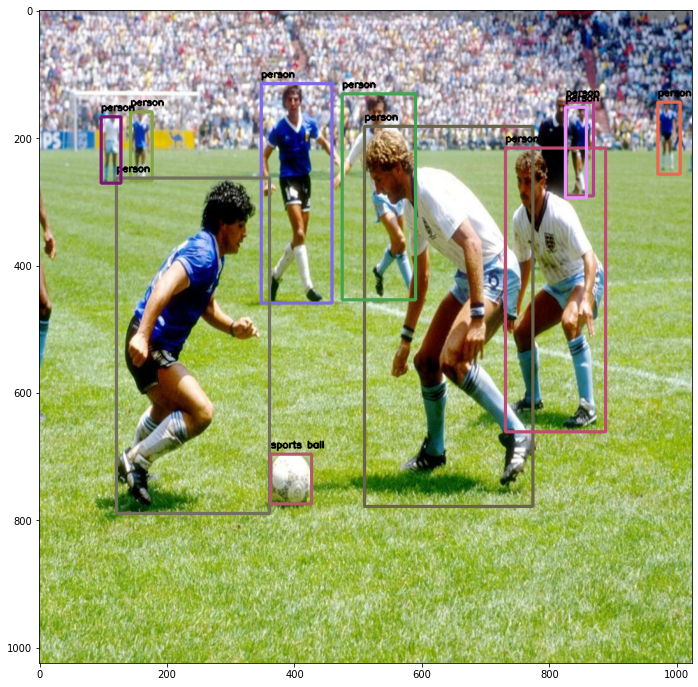

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 12))
axis = fig.add_subplot()
plt.imshow(image)
plt.show()

### References

[1]. Joseph Redmon, Ali Farhadi [YOLOv3: An Incremental Improvement](https://arxiv.org/abs/1804.02767) (April 2018)   
   
[2]. Joseph Redmon, Ali Farhadi [Yolo9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)  

[3]. Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2016)
  
[4]. Alexey Bochkovskiy, Chien-Yao Wang, Hong-Yuan Mark Liao [YOLOv4: Optimal Speed and Accuracy of Object Detection](https://arxiv.org/abs/2004.10934) (2020)
  
[5]. Rokas Balsys [YOLO v3 theory explained](https://pylessons.com/YOLOv3-introduction/)  (July 2019)       
 
[6]. [How to Perform Object Detection With YOLOv3 in Keras](https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/)

[7]. [DarkNet Github Repo](https://github.com/pjreddie/darknet)
   
[8]. [DarkNet Site for YOLO](https://pjreddie.com/darknet/yolo/)
   
[9]. [Keras(TF backend) implementation of yolo v3 objects detection](https://github.com/xiaochus/YOLOv3/blob/master/model/darknet53.py)
   